

predict arrest outcome

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# models
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, confusion_matrix, plot_confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import Lasso

In [3]:
#load data
df = pd.read_csv('data/cleaned_df.csv')

#change frisk and arrest flags to 1 and 0
df.replace({'Frisk_Flag' : { 'Y' : 1, 'N' : 0}}, inplace=True)
df.replace({'Arrest_Flag' : { 'Y' : 1, 'N' : 0}}, inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Subject_Age_Group         52147 non-null  object
 1   Was_Weapon_Reported       52147 non-null  object
 2   Officer_Gender            52147 non-null  object
 3   Officer_Race              52147 non-null  object
 4   Subject_Perceived_Race    52147 non-null  object
 5   Subject_Perceived_Gender  52147 non-null  object
 6   Arrest_Flag               52147 non-null  int64 
 7   Frisk_Flag                52147 non-null  int64 
 8   Officer_Age               52147 non-null  int64 
dtypes: int64(3), object(6)
memory usage: 3.6+ MB


First the non-numeric variables need to be split into data types that can be properly interpreted by our classifiers.

We drop the first of each of these dummies to reduce unneccessary correlation betweel features.

In [4]:
dummies_df = pd.get_dummies(df, drop_first=True)
dummies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52147 entries, 0 to 52146
Data columns (total 27 columns):
 #   Column                                                            Non-Null Count  Dtype
---  ------                                                            --------------  -----
 0   Arrest_Flag                                                       52147 non-null  int64
 1   Frisk_Flag                                                        52147 non-null  int64
 2   Officer_Age                                                       52147 non-null  int64
 3   Subject_Age_Group_1 - 17                                          52147 non-null  uint8
 4   Subject_Age_Group_18 - 25                                         52147 non-null  uint8
 5   Subject_Age_Group_26 - 35                                         52147 non-null  uint8
 6   Subject_Age_Group_36 - 45                                         52147 non-null  uint8
 7   Subject_Age_Group_46 - 55                        

In [5]:
#separate arrest outcome and train test split

X= dummies_df.drop('Arrest_Flag', axis=1)
y = dummies_df['Arrest_Flag']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

In [71]:
#show imbalance of arrest flags

y_train.value_counts()

0    35563
1     3547
Name: Arrest_Flag, dtype: int64

Because of the imbalance of Arrests vs Non Arrests, we will use SMOTE to add synthetic data. 

In [72]:
smote = SMOTE(random_state = 11)
X_train, y_train = smote.fit_resample(X_train, y_train)
y_train.value_counts()

1    35563
0    35563
Name: Arrest_Flag, dtype: int64

FEATURE SELECTION

WITH LASSO

(reduces low features to 0!)

In [77]:
scaler = StandardScaler()
# fit the scaler to the training data
scaler.fit(X_train)
#transform the training data
X_trainFS = pd.DataFrame(data = scaler.transform(X_train), columns = X.columns)
#transform the testing dat
X_testFS = pd.DataFrame(data = scaler.transform(X_test), columns = X.columns)

In [78]:
lasso = Lasso(alpha = 0.001, normalize = False)
lasso = lasso.fit(X_train, y_train)
y_train_predFS = lasso.predict(X_train)
# y_test_pred_fs = lasso.predict(X_test_fs)

In [1]:
lasso.coef_

NameError: name 'lasso' is not defined

<AxesSubplot:title={'center':'Modal Coefficients'}>

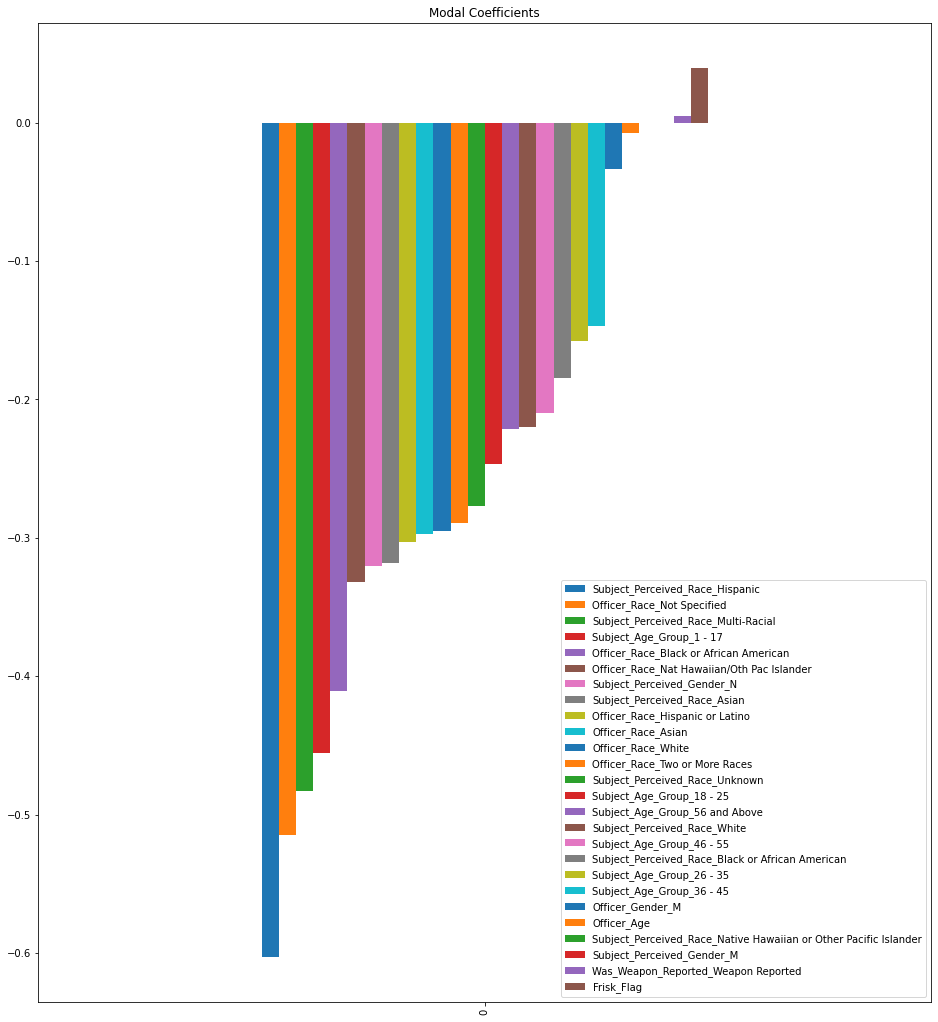

In [80]:
lasso_coef = pd.DataFrame(data=lasso.coef_).T
lasso_coef.columns = X_trainFS.columns
lasso_coef = lasso_coef.T.sort_values(by=0).T
lasso_coef.plot(kind='bar', title='Modal Coefficients', legend=True, figsize=(16,18))

In [83]:
lasso_coef.T

,0
Subject_Perceived_Race_Hispanic,-0.602854
Officer_Race_Not Specified,-0.514430
Subject_Perceived_Race_Multi-Racial,-0.482995
Subject_Age_Group_1 - 17,-0.455502
Officer_Race_Black or African American,-0.410408
Officer_Race_Nat Hawaiian/Oth Pac Islander,-0.331783
Subject_Perceived_Gender_N,-0.320475
Subject_Perceived_Race_Asian,-0.318351
Officer_Race_Hispanic or Latino,-0.302680
Officer_Race_Asian,-0.297190


In [82]:
#adjust? explain? thoughts?

Now we test various models. 

#talk about evaluation scores! list all, choose most important

#using f1 but looking at all

In this analysis, we will test Logistic Regression, KNN, Decision Trees, Random Forest, and XGBoost

In [81]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
pred = logreg.predict(X_test)

log_f1 = metrics.f1_score(y_test, pred)
log_acc = metrics.accuracy_score(y_test, pred)

print('Test F1 Score: ', log_f1)
print('Test Accuracy Score: ', log_acc)

Test F1 Score:  0.18144400617389814
Test Accuracy Score:  0.6338881644550126


C:\Users\shade\anaconda3\envs\learn-env\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [30]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
pred = knn.predict(X_test)

knn_f1 = metrics.f1_score(y_test, pred)
knn_acc = metrics.accuracy_score(y_test, pred)

print('Test F1 Score: ', knn_f1)
print('Test Accuracy Score: ', knn_acc)

Test F1 Score:  0.17370483239007403
Test Accuracy Score:  0.7088287182634042


In [14]:
dtree = DecisionTreeClassifier(max_depth=3)
dtree.fit(X_train, y_train)
pred = dtree.predict(X_test)

dtree_f1 = metrics.f1_score(y_test, pred)
dtree_acc = metrics.accuracy_score(y_test, pred)

print('Test F1 Score: ', dtree_f1)
print('Test Accuracy Score: ', dtree_acc)

Test F1 Score:  0.18955175046351838
Test Accuracy Score:  0.4300069034287029


In [15]:
forest = RandomForestClassifier(max_depth=3)
forest.fit(X_train, y_train)
pred = forest.predict(X_test)

forest_f1 = metrics.f1_score(y_test, pred)
forest_acc = metrics.accuracy_score(y_test, pred)

print('Test F1 Score: ', forest_f1)
print('Test Accuracy Score: ', forest_acc)

Test F1 Score:  0.19961380642046828
Test Accuracy Score:  0.4912940093579811


In [18]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

xgb_f1 = metrics.f1_score(y_test, pred)
xgb_acc = metrics.accuracy_score(y_test, pred)

print('Test F1 Score: ', xgb_f1)
print('Test Accuracy Score: ', xgb_acc)

Test F1 Score:  0.19144385026737967
Test Accuracy Score:  0.6520671933727085


Now we run our data through a model pipeline.

param1 = {}
param1['classifier__n_estimators'] = [10, 50, 100, 250]
param1['classifier__max_depth'] = [5, 10, 20]
param1['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param1['classifier'] = [clf1]

param2 = {}
param2['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param2['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param2['classifier'] = [clf2]

param3 = {}
param3['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param3['classifier__penalty'] = ['l1', 'l2']
param3['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param3['classifier'] = [clf3]

param4 = {}
param4['classifier__max_depth'] = [5,10,25,None]
param4['classifier__min_samples_split'] = [2,5,10]
param4['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param4['classifier'] = [clf4]

param5 = {}
param5['classifier__n_neighbors'] = [2,5,10,25,50]
param5['classifier'] = [clf5]

param6 = {}
param6['classifier__alpha'] = [10**0, 10**1, 10**2]
param6['classifier'] = [clf6]

param7 = {}
param7['classifier__n_estimators'] = [10, 50, 100, 250]
param7['classifier__max_depth'] = [5, 10, 20]
param7['classifier'] = [clf7]

pipeline = Pipeline([('classifier', clf1)])
params = [param1, param2, param3, param4, param5, param6, param7]

In [6]:
#split the data to test & training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 5, stratify = y)

#build the pipline with upsampling & scaling the data
pipeline = imbpipeline([('sm', SMOTE(random_state = 5,
                                     sampling_strategy = 'not majority')),
               ('scale', StandardScaler()),
               ('clf', LogisticRegression())
              ])

#paramters for tuning
parameters = [
    {'clf' : [ LogisticRegression(random_state = 5)],
    'clf__C' : np.logspace(-5, 8, 10),
    'clf__solver' : ['lbfgs']},
    {'clf' : [ RandomForestClassifier(random_state = 5)],
    'clf__max_depth':[4, 3, None],
    'clf__n_estimators' : [50,100, 120, 140],
    'clf__max_features' : ['auto', 2, 4]},
]

#create the grid search object
cv = GridSearchCV(pipeline,
                  param_grid=parameters,
                  refit = True,
                  cv = 5, 
                  verbose = True,
                  n_jobs = -1)

#fit the data
cv.fit(X_train, y_train)

Fitting 5 folds for each of 46 candidates, totalling 230 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.3s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 230 out of 230 | elapsed:  2.6min finished


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('sm',
                                        SMOTE(random_state=5,
                                              sampling_strategy='not '
                                                                'majority')),
                                       ('scale', StandardScaler()),
                                       ('clf', LogisticRegression())]),
             n_jobs=-1,
             param_grid=[{'clf': [LogisticRegression(random_state=5)],
                          'clf__C': array([1.00000000e-05, 2.78255940e-04, 7.74263683e-03, 2.15443469e-01,
       5.99484250e+00, 1.66810054e+02, 4.64158883e+03, 1.29154967e+05,
       3.59381366e+06, 1.00000000e+08]),
                          'clf__solver': ['lbfgs']},
                         {'clf': [RandomForestClassifier(n_estimators=140,
                                                         random_state=5)],
                          'clf__max_depth': [4, 3, None],
         

In [7]:
cv.best_params_

{'clf': RandomForestClassifier(n_estimators=140, random_state=5),
 'clf__max_depth': None,
 'clf__max_features': 'auto',
 'clf__n_estimators': 140}

In [8]:
#predict on the test set
y_pred = cv.predict(X_test)

#capture the prediction probabilities
y_predict_proba = cv.predict_proba(X_test)[:,1]

In [11]:
#scoring metrics
acc_score = cv.score(X_test, y_test)

print('The accuracy score is: {}'.format(acc_score))


#print the confusion matrix and classification report from the best model
print(confusion_matrix(y_test, y_pred))

The accuracy score is: 0.6895758226585871
[[8534 3321]
 [ 726  456]]


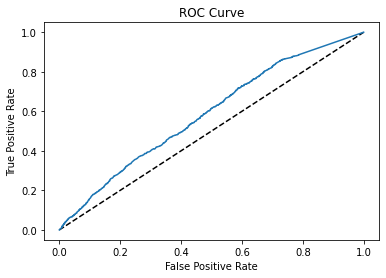

In [12]:
# Generate ROC curve values fpr, tpr, thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_predict_proba)

# Plot ROC curve
_=plt.plot([0, 1], [0, 1], 'k--')
_=plt.plot(fpr, tpr)
_=plt.xlabel('False Positive Rate')
_=plt.ylabel('True Positive Rate')
_=plt.title('ROC Curve')
plt.show()